In [5]:
# install dependencies
!pip install diffusers
!pip install transformers

In [7]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "runwayml/stable-diffusion-v1-5"
sd_pipeline = StableDiffusionPipeline.from_pretrained(model_id,
                                                      torch_dtype=torch.float16)
sd_pipeline = sd_pipeline.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [8]:
def get_completion_sd(prompt):
  negative_prompt = """
  simple background, duplicate, low quality, lowest quality,
  bad anatomy, bad proportions, extra digits, lowres, username,
  artist name, error, duplicate, watermark, signature, text,
  extra digit, fewer digits, worst quality, jpeg artifacts, blurry
  """
  return sd_pipeline(prompt, negative_prompt=negative_prompt).images[0]

In [9]:
#let's prompt

# prompt = "astronaut, riding a horse, on mars, human colony"
# prompt = "children, playing in disneyland, view from a distance"
prompt = """baby llama, wearing red muffler,
grazing, open field, sunset
"""
print(prompt)
sd_image = get_completion_sd(prompt)
sd_image.save("./llama.jpg")

baby llama, wearing red muffler,
grazing, open field, sunset



  0%|          | 0/50 [00:00<?, ?it/s]

### Build AI Image Generator

In [1]:
!pip install gradio==3.48.0

In [2]:
import gradio as gr

In [ ]:
def get_completion(category, style, color_scheme, pattern, material, fit, occasion, season):
    PROMPT_TEMPLATE = """A professional fashion model wearing a {category}, designed in {style} style with {color_scheme} colors and a {pattern} pattern. The outfit is crafted from {material}, featuring a {fit} fit, perfect for {occasion} and ideal for {season} wear. The model has a smooth, mannequin-like face with subtle contours, minimal facial details, and a neutral expression, ensuring a fashion-focused presentation. Captured in a high-end fashion studio with professional lighting, this ultra-realistic 8K UHD image highlights the outfit’s intricate textures and design. The model poses confidently against a pure white background, maintaining a clean and professional aesthetic."""

    prompt = PROMPT_TEMPLATE.format(
        category=category, style=style, color_scheme=color_scheme,
        pattern=pattern, material=material, fit=fit,
        occasion=occasion, season=season
    )

    negative_prompt = """
    simple background, duplicate, low quality, lowest quality,
    bad anatomy, bad proportions, extra digits, lowres, username,
    artist name, error, duplicate, watermark, signature, text,
    extra digit, fewer digits, worst quality, jpeg artifacts, blurry face
    """

    return sd_pipeline(prompt, negative_prompt=negative_prompt).images[0]

categories = ["Dress", "T-shirt", "Jeans", "Jacket","Shirt and Jeans","Lehenga","Churidar","Saree","Gown"]
styles = ["Modern", "Vintage", "Casual", "Elegant","Traditional"]
color_schemes = ["Monochrome", "Pastel", "Vibrant"]
patterns = ["Striped", "Floral", "Plain","Embroidery"]
materials = ["Cotton", "Silk", "Denim", "Leather","Georgette","Crepe"]
fits = ["Slim", "Regular", "Loose"]
occasions = ["Formal", "Casual", "Party"]
seasons = ["Summer", "Winter","Normal"]

genai_app = gr.Interface(
    fn=get_completion,
    inputs=[
        gr.Dropdown(choices=categories, label="Category"),
        gr.Dropdown(choices=styles, label="Style"),
        gr.Dropdown(choices=color_schemes, label="Color Scheme"),
        gr.Dropdown(choices=patterns, label="Pattern"),
        gr.Dropdown(choices=materials, label="Material"),
        gr.Dropdown(choices=fits, label="Fit"),
        gr.Dropdown(choices=occasions, label="Occasion"),
        gr.Dropdown(choices=seasons, label="Season")
    ],
    outputs=[gr.Image(label="Generated Image")],
    title="Fashion AI Image Generator",
    description="Select options to generate a fashion photography image using Stable Diffusion.",
    allow_flagging="never"
)

genai_app.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
IMPORTANT: You are using gradio version 3.48.0, however version 4.44.1 is available, please upgrade.
--------
Running on public URL: https://19ecdb01ba4594737c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
pip install --upgrade gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 84.8 MB/s eta 0:00:00
  Attempting uninstall: gradio-client
    Found existing installation: gradio_client 0.6.1
    Uninstalling gradio_client-0.6.1:
      Successfully uninstalled gradio_client-0.6.1
  Attempting uninstall: gradio
    Found existing installation: gradio 3.48.0
    Uninstalling gradio-3.48.0:
      Successfully uninstalled gradio-3.48.0


In [ ]:
import cv2
import numpy as np
import gradio as gr
from diffusers import StableDiffusionPipeline
from PIL import Image

# Load Stable Diffusion model
sd_pipeline = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to("cuda")

def overlay_face(fashion_image, face_image):
    if isinstance(face_image, str):  # If face image is a file path
        face_image = cv2.imread(face_image)

    if face_image is None or not isinstance(face_image, np.ndarray):
        print("Invalid face image input!")
        return fashion_image  # Return the original fashion image

    # Convert face image to grayscale
    gray_face = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)

    # Load pre-trained face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

    # Detect faces in the face image
    faces = face_cascade.detectMultiScale(gray_face, scaleFactor=1.3, minNeighbors=5)

    if len(faces) == 0:
        print("No face detected!")
        return fashion_image  # Return the original if no face is found

    x, y, w, h = faces[0]  # Get the first detected face
    face_crop = face_image[y:y+h, x:x+w]  # Crop the detected face

    # Convert fashion image from PIL to NumPy if needed
    if isinstance(fashion_image, Image.Image):
        fashion_image = np.array(fashion_image)

    # Convert to grayscale for face detection on fashion image
    gray_fashion = cv2.cvtColor(fashion_image, cv2.COLOR_BGR2GRAY)

    # Detect face in the generated fashion image
    model_faces = face_cascade.detectMultiScale(gray_fashion, scaleFactor=1.1, minNeighbors=5)

    if len(model_faces) == 0:
        print("No face detected on model!")
        return fashion_image

    # Get the model's face position
    mx, my, mw, mh = model_faces[0]

    # Resize the face to fit the model's face size
    face_resized = cv2.resize(face_crop, (mw, mh))

    # Blend the face onto the model's face
    fashion_image[my:my+mh, mx:mx+mw] = face_resized

    return fashion_image

def get_completion(category, style, color_scheme, pattern, material, fit, occasion, season, face_image):
    PROMPT_TEMPLATE = """A professional fashion model wearing a {category}, designed in {style} style with {color_scheme} colors and a {pattern} pattern. The outfit is crafted from {material}, featuring a {fit} fit, perfect for {occasion} and ideal for {season} wear. The model has a smooth, mannequin-like face with subtle contours, minimal facial details, and a neutral expression, ensuring a fashion-focused presentation. Captured in a high-end fashion studio with professional lighting, this ultra-realistic 8K UHD image highlights the outfit’s intricate textures and design. The model poses confidently against a pure white background, maintaining a clean and professional aesthetic."""

    prompt = PROMPT_TEMPLATE.format(
        category=category, style=style, color_scheme=color_scheme,
        pattern=pattern, material=material, fit=fit,
        occasion=occasion, season=season
    )

    # Generate fashion model image
    generated_image = sd_pipeline(prompt, guidance_scale=7.5).images[0]

    # Overlay face if provided
    if isinstance(face_image, np.ndarray) or isinstance(face_image, str):
        generated_image = overlay_face(generated_image, face_image)

    # Convert back to PIL image
    if isinstance(generated_image, np.ndarray):
        generated_image = Image.fromarray(generated_image)

    return generated_image

# Dropdown options
categories = ["Dress", "T-shirt", "Jeans", "Jacket", "Shirt and Jeans", "Lehenga", "Churidar", "Saree", "Gown"]
styles = ["Modern", "Vintage", "Casual", "Elegant", "Traditional"]
color_schemes = ["Monochrome", "Pastel", "Vibrant"]
patterns = ["Striped", "Floral", "Plain", "Embroidery"]
materials = ["Cotton", "Silk", "Denim", "Leather", "Georgette", "Crepe"]
fits = ["Slim", "Regular", "Loose"]
occasions = ["Formal", "Casual", "Party"]
seasons = ["Summer", "Winter", "Normal"]

# Gradio UI
genai_app = gr.Interface(
    fn=get_completion,
    inputs=[
        gr.Dropdown(choices=categories, label="Category"),
        gr.Dropdown(choices=styles, label="Style"),
        gr.Dropdown(choices=color_schemes, label="Color Scheme"),
        gr.Dropdown(choices=patterns, label="Pattern"),
        gr.Dropdown(choices=materials, label="Material"),
        gr.Dropdown(choices=fits, label="Fit"),
        gr.Dropdown(choices=occasions, label="Occasion"),
        gr.Dropdown(choices=seasons, label="Season"),
        gr.Image(type="filepath", label="Upload Your Face")  # Ensure correct input type
    ],
    outputs=gr.Image(label="Generated Image with Your Face"),
    title="Fashion AI Image Generator",
    description="Select options to generate a fashion photography image using Stable Diffusion, with an option to overlay your face onto the model.",
    allow_flagging="never"
)

genai_app.launch()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
IMPORTANT: You are using gradio version 3.48.0, however version 4.44.1 is available, please upgrade.
--------
Running on public URL: https://4d469bdec823b34668.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
import cv2
import numpy as np
import gradio as gr
from diffusers import StableDiffusionPipeline
from PIL import Image

# Load Stable Diffusion model
sd_pipeline = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to("cuda")

def apply_generated_clothing(uploaded_image, category, style, color_scheme, pattern, material, fit, occasion, season):
    PROMPT_TEMPLATE = """A professional fashion model wearing a {category}, designed in {style} style with {color_scheme} colors and a {pattern} pattern. The outfit is crafted from {material}, featuring a {fit} fit, perfect for {occasion} and ideal for {season} wear. The model has a smooth, mannequin-like face with subtle contours, minimal facial details, and a neutral expression, ensuring a fashion-focused presentation. Captured in a high-end fashion studio with professional lighting, this ultra-realistic 8K UHD image highlights the outfit’s intricate textures and design. The model poses confidently against a pure white background, maintaining a clean and professional aesthetic."""

    prompt = PROMPT_TEMPLATE.format(
        category=category, style=style, color_scheme=color_scheme,
        pattern=pattern, material=material, fit=fit,
        occasion=occasion, season=season
    )

    # Generate only the clothing
    generated_image = sd_pipeline(prompt, guidance_scale=7.5).images[0]

    # Convert images to NumPy arrays for processing
    uploaded_np = np.array(uploaded_image)
    generated_np = np.array(generated_image)

    # Extract clothing from the generated image
    gray_generated = cv2.cvtColor(generated_np, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray_generated, 128, 255, cv2.THRESH_BINARY)

    # Blend the clothing onto the uploaded image
    result = uploaded_np.copy()
    result[mask > 0] = generated_np[mask > 0]  # Apply clothing while keeping the face

    return Image.fromarray(result)

# Dropdown options
categories = ["Dress", "T-shirt", "Jeans", "Jacket", "Shirt and Jeans", "Lehenga", "Churidar", "Saree", "Gown"]
styles = ["Modern", "Vintage", "Casual", "Elegant", "Traditional"]
color_schemes = ["Monochrome", "Pastel", "Vibrant"]
patterns = ["Striped", "Floral", "Plain", "Embroidery"]
materials = ["Cotton", "Silk", "Denim", "Leather", "Georgette", "Crepe"]
fits = ["Slim", "Regular", "Loose"]
occasions = ["Formal", "Casual", "Party"]
seasons = ["Summer", "Winter", "Normal"]

# Gradio UI
genai_app = gr.Interface(
    fn=apply_generated_clothing,
    inputs=[
        gr.Image(type="pil", label="Upload Your Image"),
        gr.Dropdown(choices=categories, label="Category"),
        gr.Dropdown(choices=styles, label="Style"),
        gr.Dropdown(choices=color_schemes, label="Color Scheme"),
        gr.Dropdown(choices=patterns, label="Pattern"),
        gr.Dropdown(choices=materials, label="Material"),
        gr.Dropdown(choices=fits, label="Fit"),
        gr.Dropdown(choices=occasions, label="Occasion"),
        gr.Dropdown(choices=seasons, label="Season"),
    ],
    outputs=gr.Image(label="Generated Image with Your Clothing"),
    title="Fashion AI Image Generator",
    description="Upload your image, select fashion options, and apply the generated clothing while keeping your face.",
    allow_flagging="never"
)

genai_app.launch()


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
IMPORTANT: You are using gradio version 3.48.0, however version 4.44.1 is available, please upgrade.
--------
Running on public URL: https://b561fa930788122a94.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
import cv2
import numpy as np
import gradio as gr
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline
from PIL import Image
import torch

# Load Stable Diffusion models
device = "cuda" if torch.cuda.is_available() else "cpu"

# Text-to-Image Pipeline (Original)
sd_pipeline = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to(device)

# Image-to-Image Pipeline (For Similar Image Generation)
img2img_pipeline = StableDiffusionImg2ImgPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to(device)

def overlay_face(fashion_image, face_image):
    if isinstance(face_image, str):  # If face image is a file path
        face_image = cv2.imread(face_image)

    if face_image is None or not isinstance(face_image, np.ndarray):
        print("Invalid face image input!")
        return fashion_image  # Return the original fashion image

    # Convert face image to grayscale
    gray_face = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)

    # Load pre-trained face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

    # Detect faces in the face image
    faces = face_cascade.detectMultiScale(gray_face, scaleFactor=1.3, minNeighbors=5)

    if len(faces) == 0:
        print("No face detected!")
        return fashion_image  # Return the original if no face is found

    x, y, w, h = faces[0]  # Get the first detected face
    face_crop = face_image[y:y+h, x:x+w]  # Crop the detected face

    # Convert fashion image from PIL to NumPy if needed
    if isinstance(fashion_image, Image.Image):
        fashion_image = np.array(fashion_image)

    # Convert to grayscale for face detection on fashion image
    gray_fashion = cv2.cvtColor(fashion_image, cv2.COLOR_BGR2GRAY)

    # Detect face in the generated fashion image
    model_faces = face_cascade.detectMultiScale(gray_fashion, scaleFactor=1.1, minNeighbors=5)

    if len(model_faces) == 0:
        print("No face detected on model!")
        return fashion_image

    # Get the model's face position
    mx, my, mw, mh = model_faces[0]

    # Resize the face to fit the model's face size
    face_resized = cv2.resize(face_crop, (mw, mh))

    # Blend the face onto the model's face
    fashion_image[my:my+mh, mx:mx+mw] = face_resized

    return fashion_image

def generate_similar_image(reference_image, face_image=None):
    """Generate an image similar to the uploaded reference image using img2img."""

    if isinstance(reference_image, str):
        reference_image = Image.open(reference_image).convert("RGB")

    # Resize image for Stable Diffusion input
    reference_image = reference_image.resize((512, 512))

    # Use img2img pipeline to generate a similar image
    similar_image = img2img_pipeline(prompt="", image=reference_image, strength=0.7, guidance_scale=7.5).images[0]

    # Overlay face if provided
    if face_image:
        similar_image = overlay_face(similar_image, face_image)

    return similar_image

# Gradio UI
genai_app = gr.Interface(
    fn=generate_similar_image,
    inputs=[
        gr.Image(type="filepath", label="Upload Reference Image"),  # Reference image for similarity
        gr.Image(type="filepath", label="Upload Your Face (Optional)")  # Face overlay
    ],
    outputs=gr.Image(label="Generated Similar Image"),
    title="Fashion AI Similar Image Generator",
    description="Upload a fashion image, and the AI will generate a similar image. Optionally, upload your face to blend into the model.",
    allow_flagging="never"
)

genai_app.launch()


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

IMPORTANT: You are using gradio version 3.48.0, however version 4.44.1 is available, please upgrade.
--------
Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://f365224ad13fec33a7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [4]:
# Install necessary libraries
!pip install diffusers gradio transformers torch torchvision torchaudio pillow opencv-python-headless

import cv2
import numpy as np
import torch
import gradio as gr
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline
from PIL import Image

# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load Stable Diffusion model (Text-to-Image)
sd_pipeline = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to(device)

# Load Stable Diffusion model (Image-to-Image)
img2img_pipeline = StableDiffusionImg2ImgPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to(device)

def overlay_face(fashion_image, face_image):
    """Overlay user's face onto the generated fashion model image."""
    if isinstance(face_image, str):  # If it's a file path
        face_image = cv2.imread(face_image)

    if face_image is None or not isinstance(face_image, np.ndarray):
        print("Invalid face image input!")
        return fashion_image  # Return the original fashion image

    # Convert face image to grayscale
    gray_face = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)

    # Load pre-trained face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

    # Detect faces
    faces = face_cascade.detectMultiScale(gray_face, scaleFactor=1.3, minNeighbors=5)

    if len(faces) == 0:
        print("No face detected!")
        return fashion_image

    x, y, w, h = faces[0]
    face_crop = face_image[y:y+h, x:x+w]

    # Convert fashion image from PIL to NumPy
    if isinstance(fashion_image, Image.Image):
        fashion_image = np.array(fashion_image)

    # Convert to grayscale for face detection
    gray_fashion = cv2.cvtColor(fashion_image, cv2.COLOR_BGR2GRAY)

    # Detect face in generated fashion image
    model_faces = face_cascade.detectMultiScale(gray_fashion, scaleFactor=1.1, minNeighbors=5)

    if len(model_faces) == 0:
        print("No face detected on model!")
        return fashion_image

    mx, my, mw, mh = model_faces[0]
    face_resized = cv2.resize(face_crop, (mw, mh))

    # Blend the face onto the model's face
    fashion_image[my:my+mh, mx:mx+mw] = face_resized

    return fashion_image

def generate_fashion_image(category, style, color_scheme, pattern, material, fit, occasion, season, face_image):
    """Generate fashion model image using Stable Diffusion."""
    PROMPT_TEMPLATE = """A professional fashion model wearing a {category}, designed in {style} style with {color_scheme} colors and a {pattern} pattern.
    The outfit is crafted from {material}, featuring a {fit} fit, perfect for {occasion} and ideal for {season} wear.
    The model has a smooth, mannequin-like face with minimal facial details and a neutral expression.
    Captured in a high-end fashion studio with professional lighting, this ultra-realistic 8K UHD image highlights the outfit’s intricate textures and design."""

    prompt = PROMPT_TEMPLATE.format(
        category=category, style=style, color_scheme=color_scheme,
        pattern=pattern, material=material, fit=fit,
        occasion=occasion, season=season
    )

    generated_image = sd_pipeline(prompt, guidance_scale=7.5).images[0]

    if face_image:
        generated_image = overlay_face(generated_image, face_image)

    return generated_image

def generate_similar_image(reference_image, face_image=None):
    """Generate an image similar to the uploaded reference image using img2img."""
    if isinstance(reference_image, str):
        reference_image = Image.open(reference_image).convert("RGB")

    reference_image = reference_image.resize((512, 512))

    similar_image = img2img_pipeline(prompt="", image=reference_image, strength=0.7, guidance_scale=7.5).images[0]

    if face_image:
        similar_image = overlay_face(similar_image, face_image)

    return similar_image

# Dropdown options
categories = ["Dress", "T-shirt", "Jeans", "Jacket", "Shirt and Jeans", "Lehenga", "Churidar", "Saree", "Gown"]
styles = ["Modern", "Vintage", "Casual", "Elegant", "Traditional"]
color_schemes = ["Monochrome", "Pastel", "Vibrant"]
patterns = ["Striped", "Floral", "Plain", "Embroidery"]
materials = ["Cotton", "Silk", "Denim", "Leather", "Georgette", "Crepe"]
fits = ["Slim", "Regular", "Loose"]
occasions = ["Formal", "Casual", "Party"]
seasons = ["Summer", "Winter", "Normal"]

# Gradio UI for Fashion Image Generation
fashion_interface = gr.Interface(
    fn=generate_fashion_image,
    inputs=[
        gr.Dropdown(choices=categories, label="Category"),
        gr.Dropdown(choices=styles, label="Style"),
        gr.Dropdown(choices=color_schemes, label="Color Scheme"),
        gr.Dropdown(choices=patterns, label="Pattern"),
        gr.Dropdown(choices=materials, label="Material"),
        gr.Dropdown(choices=fits, label="Fit"),
        gr.Dropdown(choices=occasions, label="Occasion"),
        gr.Dropdown(choices=seasons, label="Season"),
        gr.Image(type="filepath", label="Upload Your Face (Optional)")
    ],
    outputs=gr.Image(label="Generated Fashion Image"),
    title="AI-Based Fashion Image Generator",
    description="Generate fashion model images using AI. Optionally, upload your face to blend it onto the model.",
)

# Gradio UI for Similar Image Generation
similar_interface = gr.Interface(
    fn=generate_similar_image,
    inputs=[
        gr.Image(type="filepath", label="Upload Reference Image"),
        gr.Image(type="filepath", label="Upload Your Face (Optional)")
    ],
    outputs=gr.Image(label="Generated Similar Image"),
    title="AI-Based Similar Image Generator",
    description="Upload a fashion image, and the AI will generate a similar image. Optionally, upload your face to overlay onto the model.",
)

# Combine both features into a single Gradio app
app = gr.TabbedInterface([fashion_interface, similar_interface], ["Fashion Image Generation", "Similar Image Generation"])

# Launch the app
app.launch()


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/gradio/blocks.py:1025: UserWarning: api_name predict already exists, using predict_1
  warnings.warn(


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
IMPORTANT: You are using gradio version 3.48.0, however version 4.44.1 is available, please upgrade.
--------
IMPORTANT: You are using gradio version 3.48.0, however version 4.44.1 is available, please upgrade.
--------
IMPORTANT: You are using gradio version 3.48.0, however version 4.44.1 is available, please upgrade.
--------
Running on public URL: https://f597d833aac0e818c6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [9]:
!pip install mediapipe


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


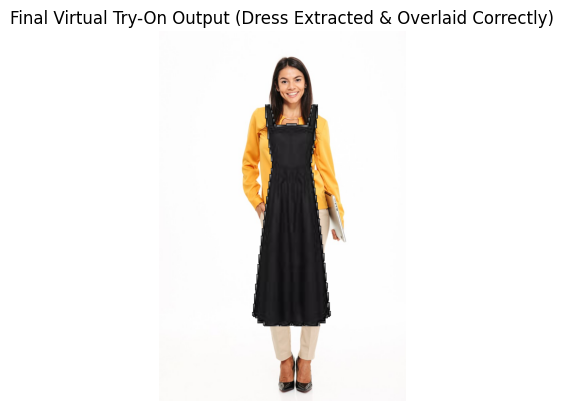

In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load user and dress images
user_img_path = "woman-1293796_641.jpg"  # Update with correct user image path
cloth_img_path = "frock3.jpg"  # Update with correct dress image path

user_img = cv2.imread(user_img_path)
cloth_img = cv2.imread(cloth_img_path)

if user_img is None or cloth_img is None:
    print("Error: Image not found. Check the file paths.")
else:
    # Convert images to RGB
    user_img = cv2.cvtColor(user_img, cv2.COLOR_BGR2RGB)
    cloth_img = cv2.cvtColor(cloth_img, cv2.COLOR_BGR2RGB)

    # **Step 1: Extract the Dress from its Background**
    gray_cloth = cv2.cvtColor(cloth_img, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray_cloth, 200, 255, cv2.THRESH_BINARY_INV)  # Create a binary mask
    cloth_extracted = cv2.bitwise_and(cloth_img, cloth_img, mask=mask)  # Extract dress using mask

    # **Step 2: Resize the Dress to Fit the User's Body**
    user_height, user_width = user_img.shape[:2]
    dress_resized = cv2.resize(cloth_extracted, (int(user_width * 0.6), int(user_height * 0.6)))

    # **Step 3: Detect Face and Position the Dress Correctly**
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    gray_user = cv2.cvtColor(user_img, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray_user, 1.1, 4)

    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        face_center_x = x + w // 2
        face_bottom_y = y + h  # Find the bottom of the face

        # Position dress below the face
        x_offset = face_center_x - dress_resized.shape[1] // 2
        y_offset = face_bottom_y + 10  # Adjust to fit properly

        # **Step 4: Overlay Dress onto User Image**
        for y in range(dress_resized.shape[0]):
            for x in range(dress_resized.shape[1]):
                if np.any(dress_resized[y, x] != [0, 0, 0]):  # Ignore black pixels (background)
                    user_img[y_offset + y, x_offset + x] = dress_resized[y, x]

    # **Step 5: Restore Hands Over the Dress (Optional)**
    # Implement hand segmentation using MediaPipe or another method if needed

    # Display final output
    plt.imshow(user_img)
    plt.title("Final Virtual Try-On Output (Dress Extracted & Overlaid Correctly)")
    plt.axis("off")
    plt.show()


In [52]:
pip install torch torchvision numpy smplx opencv-python matplotlib tensorflow keras


In [6]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from networks import HRVITON

# Load HR-VITON Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HRVITON().to(device)
model.load_state_dict(torch.load("DeepFashion_Try_On/checkpoints/hr_viton.pth", map_location=device))
model.eval()

# Image Paths (Replace with actual paths)
person_img_path = "woman-1293796_640.jpg"  # User image
cloth_img_path = "frock.jpg"  # Clothing image

# **Step 1: Preprocess Images (Resize & Normalize)**
def preprocess_image(image_path, size=(256, 256)):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    return transform(image).unsqueeze(0).to(device)

person_img = preprocess_image(person_img_path)
cloth_img = preprocess_image(cloth_img_path)

# **Step 2: Generate Pose Map (Using OpenPose)**
def generate_pose_map(image_path):
    # Use OpenPose to extract body keypoints
    # This requires running OpenPose separately and extracting keypoints
    pose_map = np.zeros((18, 256, 256))  # Placeholder for extracted keypoints
    return torch.tensor(pose_map, dtype=torch.float32).unsqueeze(0).to(device)

pose_map = generate_pose_map(person_img_path)

# **Step 3: Generate Segmentation Map (Using DeepLabV3)**
def generate_segmentation(image_path):
    # Use a pre-trained model like DeepLabV3 for parsing
    # Output should be a mask with different regions for clothes, skin, etc.
    segmentation_map = np.zeros((1, 256, 256))  # Placeholder segmentation
    return torch.tensor(segmentation_map, dtype=torch.float32).unsqueeze(0).to(device)

segmentation_map = generate_segmentation(person_img_path)

# **Step 4: Run HR-VITON Model**
with torch.no_grad():
    output = model(person_img, cloth_img, pose_map, segmentation_map)

# Convert output to image
output_img = output.squeeze().cpu().numpy().transpose(1, 2, 0)
output_img = (output_img * 0.5 + 0.5) * 255  # Convert back to image format
output_img = output_img.astype(np.uint8)

# **Step 5: Display Result**
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(Image.open(person_img_path))
plt.title("Original Person")

plt.subplot(1, 3, 2)
plt.imshow(Image.open(cloth_img_path))
plt.title("Clothing Image")

plt.subplot(1, 3, 3)
plt.imshow(output_img)
plt.title("Final Try-On Result")

plt.show()


ModuleNotFoundError: No module named 'networks'